In [ ]:
# ============================================
# SHARED CONFIGURATION
# ============================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time

# Hyperparameters
BATCH_SIZE = 64
LABEL_SMOOTHING = 0.05
DROPOUT = 0.5
EPOCHS = 40
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.01
NUM_CLASSES = 7
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# For reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Emotion labels (RAF-DB)
EMOTION_LABELS = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']

print(f"Using device: {DEVICE}")
print(f"Random seed: {RANDOM_SEED}")


Using device: cpu
Random seed: 42


In [ ]:
# ============================================
# KAGGLE DATASET DOWNLOAD
# ============================================

!pip install -q kaggle

# Upload kaggle.json (only need to run once per session)
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download RAF-DB dataset
print("\nDownloading RAF-DB dataset from Kaggle...")
!kaggle datasets download -d shuvoalok/raf-db-dataset

# Unzip dataset
print("\nExtracting dataset...")
!unzip -q raf-db-dataset.zip

print("✅ Dataset downloaded and extracted successfully!\n")


Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

Dataset URL: https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset
License(s): other
  0% 0.00/37.7M [00:00<?, ?B/s]
100% 37.7M/37.7M [00:00<00:00, 1.41GB/s]

Extracting dataset...
✅ Dataset downloaded and extracted successfully!



In [ ]:
# ============================================
# DATA LOADING AND SPLITTING
# ============================================

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    # Geometric augmentations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    # Color augmentations
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.1),

    # Blur and noise
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

    # Cutout/Random Erasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
])

# Load the original training data from RAF-DB
full_train_dataset = datasets.ImageFolder(root="./DATASET/train", transform=transform)

# Split training into train (80%) and validation (20%)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Apply different transformation to training and validation dataset
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = transform

# Load the original test data from RAF-DB (this will be your final test set)
test_dataset = datasets.ImageFolder(root="./DATASET/test", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Print dataset info
print(f"Dataset Split Summary:")
print(f"{'='*60}")
print(f"Training samples: {len(train_dataset)} ({len(train_dataset)/len(full_train_dataset)*100:.1f}%)")
print(f"Validation samples: {len(val_dataset)} ({len(val_dataset)/len(full_train_dataset)*100:.1f}%)")
print(f"Test samples: {len(test_dataset)}")
print(f"Total samples: {len(full_train_dataset) + len(test_dataset)}")
print(f"{'='*60}\n")

# Calculate class weights for imbalanced dataset
# Note: We get labels from the original full_train_dataset using the indices
train_labels = [full_train_dataset.targets[i] for i in train_dataset.indices]
train_counts = Counter(train_labels)

print(f"Class distribution in training set:")
print(f"{'='*60}")
for i in range(NUM_CLASSES):
    count = train_counts[i]
    percentage = count / len(train_dataset) * 100
    print(f"  {EMOTION_LABELS[i]:<15}: {count:>5} ({percentage:>5.1f}%)")
print(f"{'='*60}\n")

# Calculate class weights (inverse frequency)
class_counts = np.array([train_counts[i] for i in range(NUM_CLASSES)])
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * NUM_CLASSES  # Normalize
class_weights = torch.FloatTensor(class_weights).to(DEVICE)

print(f"Class weights for loss function:")
print(f"{'='*60}")
for i in range(NUM_CLASSES):
    print(f"  {EMOTION_LABELS[i]:<15}: {class_weights[i]:.4f}")
print(f"{'='*60}\n")


Dataset Split Summary:
Training samples: 9816 (80.0%)
Validation samples: 2455 (20.0%)
Test samples: 3068
Total samples: 15339

Class distribution in training set:
  Surprise       :  1026 ( 10.5%)
  Fear           :   228 (  2.3%)
  Disgust        :   564 (  5.7%)
  Happiness      :  3875 ( 39.5%)
  Sadness        :  1576 ( 16.1%)
  Anger          :   574 (  5.8%)
  Neutral        :  1973 ( 20.1%)

Class weights for loss function:
  Surprise       : 0.6640
  Fear           : 2.9879
  Disgust        : 1.2079
  Happiness      : 0.1758
  Sadness        : 0.4323
  Anger          : 1.1868
  Neutral        : 0.3453



In [ ]:
def mixup_data(x, y, alpha=1.0):
    if alpha <= 0:
        return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
# ============================================
# TRAINING AND VALIDATION FUNCTIONS
# ============================================

def train(model, loader, optimizer, criterion, epoch, mixup_alpha=0.4):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        # Apply MixUp
        images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=mixup_alpha)

        # Forward pass
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # For accuracy, use blended estimate (not exact)
        _, preds = torch.max(outputs, 1)
        correct += (lam * preds.eq(targets_a).sum().item() +
                    (1 - lam) * preds.eq(targets_b).sum().item())
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc



def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_val_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_val_acc + self.min_delta:
            self.best_val_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop




In [ ]:
# ============================================
# EVALUATION METRICS
# ============================================

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns

def evaluate_model(model, loader, model_name="Model"):
    """
    Comprehensive evaluation of a model.
    Returns: accuracy, confusion matrix, and classification metrics
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Overall accuracy
    accuracy = 100 * np.sum(all_preds == all_labels) / len(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Per-class metrics
    print(f"\n{'='*60}")
    print(f"{model_name} - Classification Report")
    print(f"{'='*60}")
    print(classification_report(all_labels, all_preds,
                                target_names=EMOTION_LABELS,
                                digits=4))

    # Precision, Recall, F1 per class
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None
    )

    print(f"\n{'='*60}")
    print(f"Per-Class Metrics Summary")
    print(f"{'='*60}")
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*60}")
    for i in range(NUM_CLASSES):
        print(f"{EMOTION_LABELS[i]:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1 = np.mean(f1)
    print(f"{'-'*60}")
    print(f"{'Average':<15} {avg_precision:<12.4f} {avg_recall:<12.4f} {avg_f1:<12.4f}")

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'support': support
    }


def measure_inference_time(model, loader, num_batches=10):
    """
    Measure average inference time per batch
    """
    model.eval()
    times = []

    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= num_batches:
                break

            images = images.to(DEVICE)

            # Measure time
            start_time = time.time()
            _ = model(images)
            end_time = time.time()

            times.append(end_time - start_time)

    avg_time = np.mean(times) * 1000  # Convert to milliseconds
    return avg_time


def count_parameters(model):
    """
    Count total and trainable parameters
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


In [ ]:
# ============================================
# PLOTTING FUNCTIONS
# ============================================

def plot_training_curves(history, model_name="Model"):
    """
    Plot training and validation loss/accuracy curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
    ax1.set_title(f'{model_name} - Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
    ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
    ax2.set_title(f'{model_name} - Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================
# EFFICIENTNET-B0 MODEL
# ============================================

# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)


# Replace final layer for 7 emotions
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(DROPOUT),
    nn.Linear(num_features, NUM_CLASSES)
)

model = model.to(DEVICE)
model_name = "EfficientNetB0"

# Print model info
total_params, trainable_params = count_parameters(model)
print(f"\n{model_name} Model Info:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")
print(f"  Pretrained: Yes (ImageNet)")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s]



EfficientNetB0 Model Info:
  Total parameters: 4,016,515
  Trainable parameters: 4,016,515
  Model size: 15.32 MB (float32)
  Pretrained: Yes (ImageNet)



Training EfficientNetB0

Epoch 01/40 | Train Loss: 1.9412 | Train Acc: 23.83% | Val Loss: 1.7522 | Val Acc: 36.05%
Epoch 02/40 | Train Loss: 1.6870 | Train Acc: 41.60% | Val Loss: 1.5091 | Val Acc: 55.11%
Epoch 03/40 | Train Loss: 1.5084 | Train Acc: 52.65% | Val Loss: 1.3525 | Val Acc: 62.16%
Epoch 04/40 | Train Loss: 1.3968 | Train Acc: 58.95% | Val Loss: 1.2771 | Val Acc: 66.40%
Epoch 05/40 | Train Loss: 1.3308 | Train Acc: 62.48% | Val Loss: 1.2194 | Val Acc: 68.55%
Epoch 06/40 | Train Loss: 1.2749 | Train Acc: 64.43% | Val Loss: 1.1901 | Val Acc: 71.08%
Epoch 07/40 | Train Loss: 1.1913 | Train Acc: 68.76% | Val Loss: 1.1641 | Val Acc: 72.83%
Epoch 08/40 | Train Loss: 1.1369 | Train Acc: 71.95% | Val Loss: 1.1493 | Val Acc: 74.38%
Epoch 09/40 | Train Loss: 1.1421 | Train Acc: 71.07% | Val Loss: 1.1320 | Val Acc: 73.16%
EarlyStopping counter: 1/7
Epoch 10/40 | Train Loss: 1.1202 | Train Acc: 71.66% | Val Loss: 1.1417 | Val Acc: 73.81%
EarlyStopping counter: 2/7
Epoch 11/40 | Train 

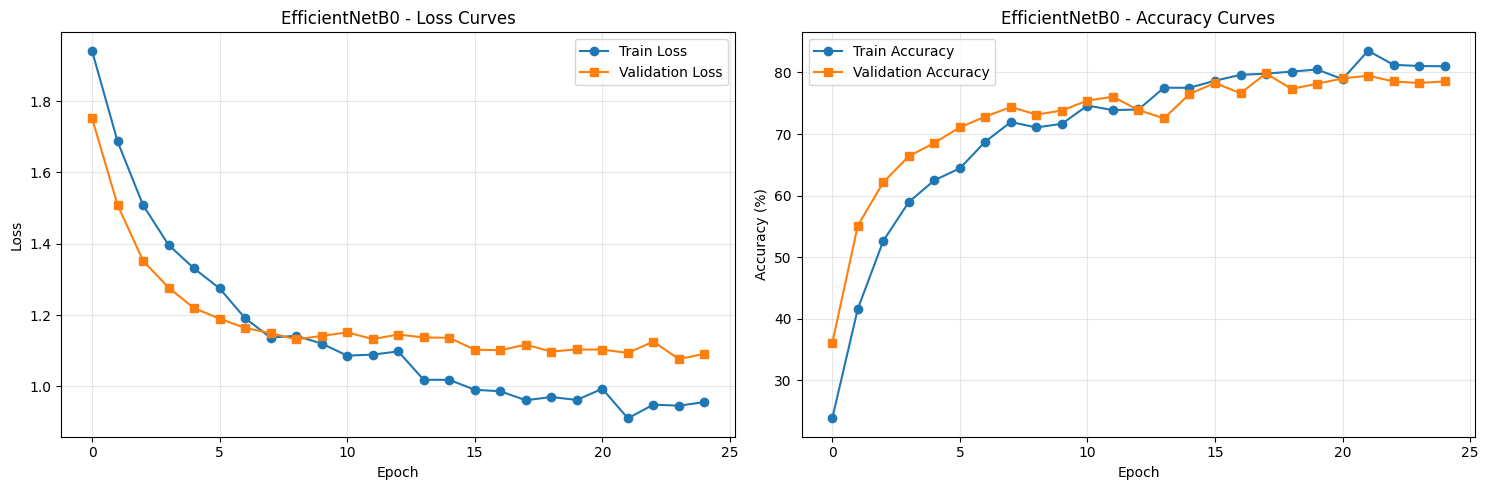

In [ ]:
# ============================================
# TRAINING LOOP
# ============================================

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTHING)

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

#scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Training
best_val_acc = 0.0
best_epoch = 0

print(f"\n{'='*60}")
print(f"Training {model_name}")
print(f"{'='*60}\n")

# Early stopping
early_stopping = EarlyStopping(patience=7, min_delta=0.001)

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), f'{model_name}_best.pth')

    # Print progress
    print(f'Epoch {epoch+1:02d}/{EPOCHS} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

    # Early stop
    if early_stopping(val_acc):
        print(f"Early stopping at epoch {epoch+1}")
        break

    # LR step
    scheduler.step()

print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"{'='*60}\n")

# Plot training curves
plot_training_curves(history, model_name)



FINAL EVALUATION - EfficientNetB0



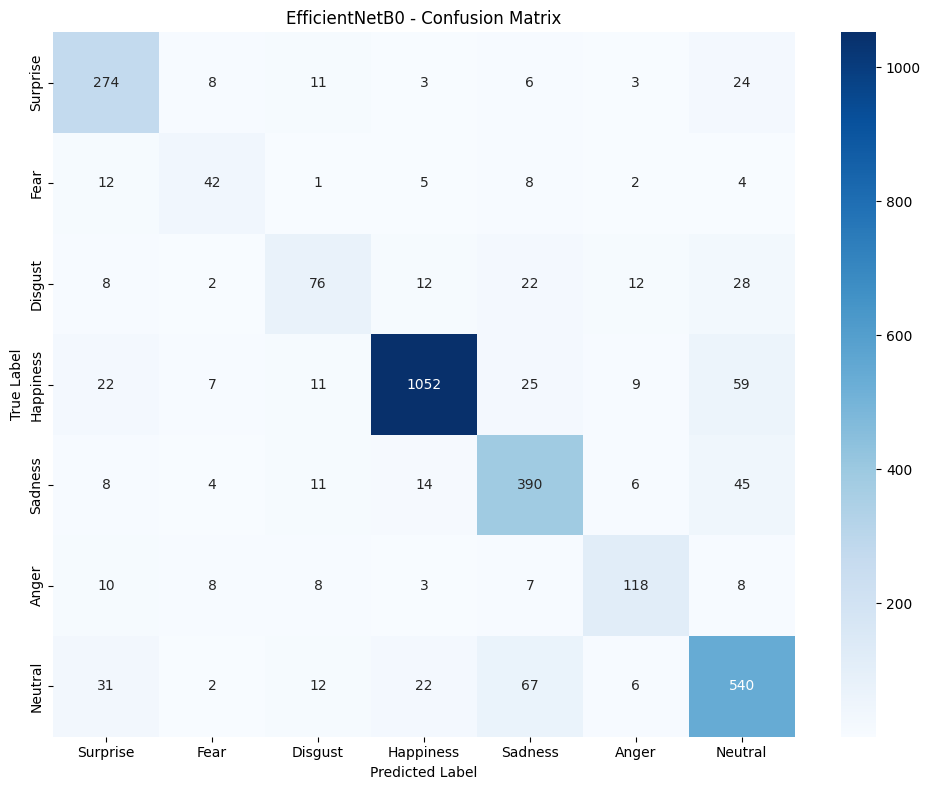


EfficientNetB0 - Classification Report
              precision    recall  f1-score   support

    Surprise     0.7507    0.8328    0.7896       329
        Fear     0.5753    0.5676    0.5714        74
     Disgust     0.5846    0.4750    0.5241       160
   Happiness     0.9469    0.8878    0.9164      1185
     Sadness     0.7429    0.8159    0.7777       478
       Anger     0.7564    0.7284    0.7421       162
     Neutral     0.7627    0.7941    0.7781       680

    accuracy                         0.8123      3068
   macro avg     0.7314    0.7288    0.7285      3068
weighted avg     0.8153    0.8123    0.8125      3068


Per-Class Metrics Summary
Class           Precision    Recall       F1-Score     Support   
------------------------------------------------------------
Surprise        0.7507       0.8328       0.7896       329       
Fear            0.5753       0.5676       0.5714       74        
Disgust         0.5846       0.4750       0.5241       160       
Happiness  

NameError: name 'best_epoch' is not defined

In [ ]:
# ============================================
# FINAL EVALUATION ON TEST SET
# ============================================

# Load best model
model.load_state_dict(torch.load(f'{model_name}_best_v6.pth', map_location=torch.device('cpu')))
model = model.to('cpu')

print(f"\n{'='*60}")
print(f"FINAL EVALUATION - {model_name}")
print(f"{'='*60}\n")

# Evaluate on test set
test_metrics = evaluate_model(model, test_loader, model_name)

# Measure inference time
inference_time = measure_inference_time(model, test_loader)

# Summary
print(f"\n{'='*60}")
print(f"{model_name} - Final Results Summary")
print(f"{'='*60}")
print(f"Test Accuracy: {test_metrics['accuracy']:.2f}%")
print(f"Average Inference Time: {inference_time:.2f} ms/batch")
print(f"Total Parameters: {total_params:,}")
print(f"Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")
print(f"{'='*60}\n")

In [ ]:
!pip install onnx
# ============================================
# EXPORT MODEL TO ONNX
# ============================================

import torch.onnx

onnx_filename = f"{model_name}.onnx"

# Load best model weights
model.load_state_dict(torch.load(f"{model_name}_best.pth"))
model.eval()

# Create a dummy input tensor (same shape as model input)
dummy_input = torch.randn(1, 3, 224, 224, device=DEVICE)

# Export the model
torch.onnx.export(
    model,                              # model being run
    dummy_input,                        # model input
    onnx_filename,                      # where to save the model
    export_params=True,                 # store trained weights inside the model file
    opset_version=17,                   # ONNX version
    do_constant_folding=True,           # optimize constants
    input_names=['input'],              # input layer name
    output_names=['output'],            # output layer name
    dynamic_axes={
        'input': {0: 'batch_size'},     # allow variable batch size
        'output': {0: 'batch_size'}
    }
)

print(f"✅ Model successfully exported to {onnx_filename}")


files.download(f"{model_name}.onnx")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 27.9 MB/s eta 0:00:00


/tmp/ipython-input-3797467454.py:18: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ Model successfully exported to EfficientNetB0.onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>